# Packages and Data

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
import math
import torch.nn.functional as F
from torch.nn import Parameter
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
file_dir  = "../input/severstal-steel-defect-detection/train_images"
df = pd.read_csv("../input/severstal-steel-defect-detection/train.csv")

In [2]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [3]:
df["ClassId"].value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

# Data Channels

In [4]:
class SteelDataset(Dataset):
    def __init__(self, df, file_dir, transform):
        self.df = df
        self.file_dir = file_dir
        self.transform = transform
    def __getitem__(self, index):
      
        image_name = self.df["ImageId"].iloc[index]
        class_id = self.df["ClassId"].iloc[index]       
        #pixels = self.df["EncodedPixels"].iloc[index] 
        image = cv2.imread(os.path.join(self.file_dir,image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = self.transform(image=image)["image"]
        one_hot = np.zeros(5)
        one_hot[class_id] = 1
        return image, one_hot

    
    def __len__(self):
        return self.df.shape[0]

In [5]:
train_transform = A.Compose([A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                             A.RandomBrightnessContrast(p=0.5),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                            ToTensorV2()]
)
val_transform = A.Compose([A.HorizontalFlip(p=0.5),
                           A.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                           ToTensorV2()])

# Split Data

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
fold1_idx, fold2_idx, fold3_idx, fold4_idx, fold5_idx, fold6_idx, fold7_idx, fold8_idx, fold9_idx, fold10_idx = kf.split(df)
fold1 = df[df.index.isin(fold1_idx[1])]
fold2 = df[df.index.isin(fold2_idx[1])]
fold3 = df[df.index.isin(fold3_idx[1])]
fold4 = df[df.index.isin(fold4_idx[1])]
fold5 = df[df.index.isin(fold5_idx[1])]
fold6 = df[df.index.isin(fold6_idx[1])]
fold7 = df[df.index.isin(fold7_idx[1])]
fold8 = df[df.index.isin(fold8_idx[1])]
fold9 = df[df.index.isin(fold9_idx[1])]
fold10 = df[df.index.isin(fold10_idx[1])]

In [7]:
fold1.to_csv("fold1.csv",index=False)
fold2.to_csv("fold2.csv",index=False)
fold3.to_csv("fold3.csv",index=False)
fold4.to_csv("fold4.csv",index=False)
fold5.to_csv("fold5.csv",index=False)
fold6.to_csv("fold6.csv",index=False)
fold7.to_csv("fold7.csv",index=False)
fold8.to_csv("fold8.csv",index=False)
fold9.to_csv("fold9.csv",index=False)
fold10.to_csv("fold10.csv",index=False)

In [8]:
train = pd.concat((fold2, fold3, fold4, fold5, fold6, fold7, fold8, fold9, fold10), axis = 0)
val = fold1

In [9]:
fold1["ClassId"].value_counts()

3    508
1     96
4     73
2     33
Name: ClassId, dtype: int64

In [10]:
train_data = SteelDataset(train, file_dir, transform =train_transform)
val_data = SteelDataset(val, file_dir, transform =val_transform)

In [11]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle=True)

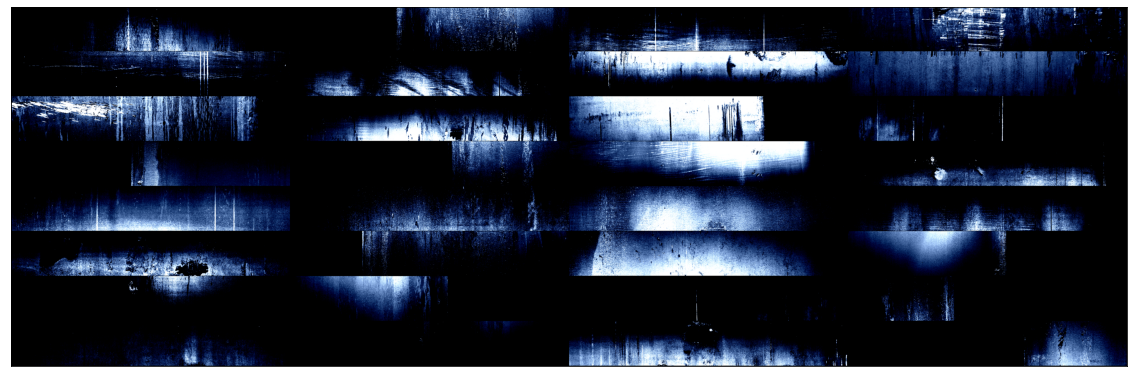

In [12]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

# Get Pretrained Model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
import torchvision.models as models
model = models.resnet34(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model.fc = nn.Linear(512,5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [15]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Start Training

In [16]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-7):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.float()

In [17]:
criterion = DiceBCELoss()

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [19]:
def train_model(model, num_epochs, criterion, train_loader, labels, optimizer):    

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_num_correct = 0 
        train_num_predictions = 0 
        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader):

            images = images.to(device).float()
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)

            _, preds = torch.max(outputs.data,1)
            _, truth = torch.max(labels.data,1)
            train_num_correct += (preds == truth).sum().item()
            train_num_predictions += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_accuracy = train_num_correct / train_num_predictions * 100
        train_losses.append(running_loss / len(train_loader))

        model.eval()    
        running_loss = 0
        val_num_correct = 0
        val_num_predictions = 0
        
        class1_num_correct = 0 
        class1_num_predictions = 0
        class2_num_correct = 0 
        class2_num_predictions = 0
        class3_num_correct = 0 
        class3_num_predictions = 0
        class4_num_correct = 0 
        class4_num_predictions = 0

        with torch.no_grad():  
            for images, labels in tqdm(val_loader):

                images = images.to(device).float()
                labels = labels.to(device).float()

                optimizer.zero_grad()
                outputs = model(images)

                _, preds = torch.max(outputs.data,1)
                _, truth = torch.max(labels.data,1)
                val_num_correct += (preds == truth).sum().item()
                val_num_predictions += labels.size(0)
                
                class1_num_correct += ((preds == 1) & (preds == truth)).sum().item()
                class1_num_predictions += (preds == 1).sum().item()
                class2_num_correct += ((preds == 2) & (preds == truth)).sum().item()
                class2_num_predictions += (preds == 2).sum().item()
                class3_num_correct += ((preds == 3) & (preds == truth)).sum().item()
                class3_num_predictions += (preds == 3).sum().item()
                class4_num_correct += ((preds == 4) & (preds == truth)).sum().item()
                class4_num_predictions += (preds == 4).sum().item()

                loss = criterion(outputs, labels)
                running_loss += loss.item()

        val_accuracy = val_num_correct / val_num_predictions * 100
        val_losses.append(running_loss / len(val_loader))
        
        class1_accuracy = (class1_num_correct + 1e-9 ) / (class1_num_predictions + 1e-9) * 100
        class2_accuracy = (class2_num_correct + 1e-9 ) / ( class2_num_predictions + 1e-9) * 100
        class3_accuracy = (class3_num_correct + 1e-9 ) / ( class3_num_predictions + 1e-9) * 100
        class4_accuracy = (class4_num_correct + 1e-9 ) / ( class4_num_predictions + 1e-9) * 100
        
        print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
              %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
        print("[class1_Acc: %.2f], [class2_Acc: %.2f], [class3: %.2f], [class4: %.2f]" \
              %(class1_accuracy, class2_accuracy, class3_accuracy, class4_accuracy))

In [20]:
train_model(model, 5, criterion, train_loader, labels, optimizer)

100%|██████████| 23/23 [00:25<00:00,  1.10s/it]


[Epoch: 1 / 5], [Trian loss: 0.672888], [Val loss: 0.652984], [Train_Acc: 72.31], [Val_Acc: 71.55]
[class1_Acc: 100.00], [class2_Acc: 100.00], [class3: 71.55], [class4: 100.00]


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


[Epoch: 2 / 5], [Trian loss: 0.610572], [Val loss: 0.612924], [Train_Acc: 72.70], [Val_Acc: 71.55]
[class1_Acc: 100.00], [class2_Acc: 100.00], [class3: 71.55], [class4: 100.00]


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


[Epoch: 3 / 5], [Trian loss: 0.582291], [Val loss: 0.566707], [Train_Acc: 73.14], [Val_Acc: 71.97]
[class1_Acc: 100.00], [class2_Acc: 100.00], [class3: 72.10], [class4: 63.64]


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


[Epoch: 4 / 5], [Trian loss: 0.556501], [Val loss: 0.551302], [Train_Acc: 73.77], [Val_Acc: 72.68]
[class1_Acc: 100.00], [class2_Acc: 100.00], [class3: 72.69], [class4: 72.22]


100%|██████████| 23/23 [00:21<00:00,  1.08it/s]

[Epoch: 5 / 5], [Trian loss: 0.541092], [Val loss: 0.538870], [Train_Acc: 74.33], [Val_Acc: 73.52]
[class1_Acc: 100.00], [class2_Acc: 100.00], [class3: 73.67], [class4: 70.59]


In [21]:
for p in model.parameters():
    p.requires_grad = True

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [23]:
train_model(model, 6, criterion, train_loader, labels, optimizer)

100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


[Epoch: 1 / 6], [Trian loss: 0.386328], [Val loss: 0.316723], [Train_Acc: 83.26], [Val_Acc: 87.61]
[class1_Acc: 79.01], [class2_Acc: 81.48], [class3: 92.14], [class4: 72.04]


100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


[Epoch: 2 / 6], [Trian loss: 0.288154], [Val loss: 0.257412], [Train_Acc: 88.14], [Val_Acc: 89.44]
[class1_Acc: 86.25], [class2_Acc: 81.48], [class3: 91.83], [class4: 79.22]


100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


[Epoch: 3 / 6], [Trian loss: 0.248782], [Val loss: 0.238582], [Train_Acc: 89.48], [Val_Acc: 90.00]
[class1_Acc: 82.42], [class2_Acc: 82.14], [class3: 93.55], [class4: 78.48]


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


[Epoch: 4 / 6], [Trian loss: 0.235754], [Val loss: 0.215540], [Train_Acc: 89.96], [Val_Acc: 91.27]
[class1_Acc: 86.46], [class2_Acc: 83.33], [class3: 94.51], [class4: 78.38]


100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


[Epoch: 5 / 6], [Trian loss: 0.218894], [Val loss: 0.237951], [Train_Acc: 90.79], [Val_Acc: 89.72]
[class1_Acc: 85.06], [class2_Acc: 82.14], [class3: 91.90], [class4: 81.25]


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]

[Epoch: 6 / 6], [Trian loss: 0.209746], [Val loss: 0.246661], [Train_Acc: 91.40], [Val_Acc: 89.72]
[class1_Acc: 87.18], [class2_Acc: 87.50], [class3: 92.35], [class4: 76.47]


# Save Model

In [24]:
torch.save(model, "classifier_fold1.h5")